# Introduction

In this Notebook, we will use Prudential Life Insurance's data of its policyholders and build a classifier which will try to predict different classes of its policyholders depending on the underwriting and risk assessment.

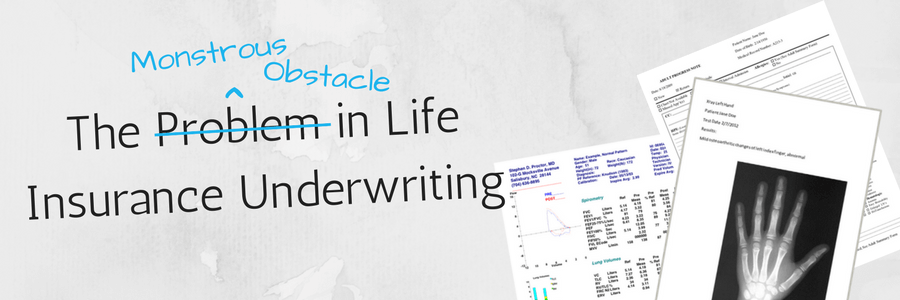

We have only used Training data for the purpose of building classifier. In the training data, we have around 60k records and around 128 features. Most of the features are masked and normalized. This makes the task of feature engineering very difficult.

For the purpose of this analysis, we will turn the multiclass classification problem to binary classification problem. We can see (ref. below) that class 8 has the highest number of records which suggests that these are clean and accepted records (i.e. policy issued to these lives on standard terms). Rest other classes can be considered as policy issuance with some extra terms and conditions (i.e. not completely clean records).

We will use various packages to solve this challenge but primarily, we will use Fastai and Sklearn libraries.

In this Notebook, we will use following approaches to build the classifier:

1. Feature engineering as much as possible
2. Using clustering techniques, creation of more features
3. Weeding out unwanted and highly correlated features

It will be soon found out that industry knowledge and feature engineering will play a major role in buildling a perfect and accurate classifier. So, let's dive in!

PS: In my earlier committed kernel, I found one bug which I have corrected in this kernel (I accidentally included dependent variable in the list of independent variable which resulted in almost 100% accuracy. Extremely sorry for this oversight.

# Loading Libraries and Data

Let's first load few libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('fivethirtyeight')

plt.figure(figsize=(25,25))

import pandas_profiling as pp

# Any results you write to the current directory are saved as output.

In [ ]:
import gc
gc.collect()

In [ ]:
# !pip install pretrainedmodels

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai==1.0.57
import fastai

from fastai import *
from fastai.vision import *
from fastai.tabular import *

# from torchvision.models import *
# import pretrainedmodels

from utils import *
import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.manifold import TSNE

from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor

from scipy.special import erfinv
import matplotlib.pyplot as plt
import torch
from torch.utils.data import *
from torch.optim import *
from fastai.tabular import *
import torch.utils.data as Data
from fastai.basics import *
from fastai.callbacks.hooks import *
from tqdm import tqdm_notebook as tqdm

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

# Normalizing Data

This function will be used to normalize the data. Its called Rank - Gaussian Normalization technique. In very simple terms, for continious data in a column are sorted as per their values and ranks are determined. These ranks are then normalized using Gaussian distribution. 

I found this technique of normalizing the continious data in dataset really helpful. 

In [ ]:
def to_gauss(x): return np.sqrt(2)*erfinv(x)  #from scipy

def normalize(data, exclude=None):
    # if not binary, normalize it
    norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()# list of sorted index
        uniform = np.linspace(start=-0.99, stop=0.99, num=n) # linsapce
        normal = to_gauss(uniform) # apply gauss to linspace
        normalized_col = pd.Series(index=sorted_idx, data=normal) # sorted idx and normalized space
        data[col] = normalized_col # column receives its corresponding rank
    return data

# Data

Let's see how does our data look like.

We will see first few entries, its shape and its statistical description

In [ ]:
df_all = pd.read_csv('../input/train.csv')

In [ ]:
df_all.head()

In [ ]:
df_all.shape

In [ ]:
df_all.columns

There are around 128 features and on a very broad level, these can be categorized into:

1. Product Information (boundary conditions)
2. Age
3. Height
4. Weight
5. BMI
6. Employment Information
7. Other insured information
8. Family History
9. Medical History
10. Medical Keywords

"Response" is the target variable in the data. Let's see the value counts of the target variable

In [ ]:
df_all['Response'].value_counts()

In [ ]:
sns.set_color_codes()
plt.figure(figsize=(12,12))
sns.countplot(df_all.Response).set_title('Dist of Response variables')

We can see that Class 8 has the highest distribution. We will assume this as clean and accepted policies on standard underwriting terms. Rest other classes can be considered as policies rejected or accepted at extra terms and conditions

In [ ]:
df_all.describe()

In [ ]:
df_all.dtypes

In [ ]:
df_all.shape

Let's plot few variables. These will be helpful in doing some very important feature engineering.

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'BMI', data=df_all,  orient='v' , ax=axes[0])
sns.distplot(df_all['BMI'],  ax=axes[1])

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'Ins_Age', data=df_all,  orient='v' , ax=axes[0])
sns.distplot(df_all['Ins_Age'],  ax=axes[1])

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'Ht', data=df_all,  orient='v' , ax=axes[0])
sns.distplot(df_all['Ht'],  ax=axes[1])

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'Wt', data=df_all,  orient='v' , ax=axes[0])
sns.distplot(df_all['Wt'],  ax=axes[1])

# Converting the Multiclass problem into Binary classes problem

As discussed above, we will turn this Multiclass classification challenge into Binary classification challenge.

In [ ]:
#create a funtion to create new target variable based on conditions
# 0 means reject
# 1 means accept

def new_target(row):
    if (row['Response']<=7):
        val=0
    elif (row['Response']==8):
        val=1
    else:
        val=2
    return val


#create a copy of original dataset
new_data=df_all.copy()

#create a new column
new_data['Final_Response']=new_data.apply(new_target,axis=1)

#print unique values of target variable
print("Unique values in Target Variable: {}".format(new_data.Final_Response.dtype))
print("Unique values in Target Variable: {}".format(new_data.Final_Response.unique()))
print("Total Number of unique values : {}".format(len(new_data.Final_Response.unique())))

#distribution plot for target classes
sns.countplot(x=new_data.Final_Response).set_title('Distribution of rows by response categories')

In [ ]:
new_data.drop(['Response'], axis=1, inplace=True)
df_all = new_data
del new_data

In [ ]:
df_all.rename(columns={'Final_Response': 'Response'}, inplace=True)

# Feature Engineering

This is perhaps the most important part of this notebook.

Based on my industry knowledge, we know that these are high risk policies:

1. Old Age
2. Obese persons
3. High BMI
4. Extremely short or tall persons

We will therefore create few features such as:

1. Person very old or very young or in middle
2. Person very short or tall or in middle
3. Person with very high BMI or low BMI or in middle
4. Persons with obesity or are very thin or in middle

We will also create few more features such as:

1. Multiplication of BMI and Age - higher the factor, higher the risk
2. Multiplication of Weight and Age - higher the factor, higher the risk
3. Multiplication of Height and Age
4. Split of Product Info 2 into numericals and characters
5. Few stats description of Medical Keywords
6. Depending on the BMI, classification of lives into High Risk or Low Risk (very low and very high BMI both are risky factors)
7. Depending on BMI, Ht, Wt, Age, creation of more features which basically categorizes the risk into different buckets

In [ ]:
#1
df_all['Product_Info_2_char'] = df_all.Product_Info_2.str[0]
#2
df_all['Product_Info_2_num'] = df_all.Product_Info_2.str[1]

#3
df_all['BMI_Age'] = df_all['BMI'] * df_all['Ins_Age']
#4
df_all['Age_Wt'] = df_all['Ins_Age'] * df_all['Wt']
#5
df_all['Age_Ht'] = df_all['Ins_Age'] * df_all['Ht']

med_keyword_columns = df_all.columns[df_all.columns.str.startswith('Medical_Keyword_')]
#6
df_all['Med_Keywords_Count'] = df_all[med_keyword_columns].sum(axis=1)

#7
df_all['Ins_Age_sq'] = df_all['Ins_Age'] * df_all['Ins_Age']
#8
df_all['Ht_sq'] = df_all['Ht'] * df_all['Ht']
#9
df_all['Wt_sq'] = df_all['Wt'] * df_all['Wt']
#10
df_all['BMI_sq'] = df_all['BMI'] * df_all['BMI']

#11
df_all['Ins_Age_cu'] = df_all['Ins_Age'] * df_all['Ins_Age'] * df_all['Ins_Age']
#12
df_all['Ht_cu'] = df_all['Ht'] * df_all['Ht'] * df_all['Ht']
#13
df_all['Wt_cu'] = df_all['Wt'] * df_all['Wt'] * df_all['Wt']
#14
df_all['BMI_cu'] = df_all['BMI'] * df_all['BMI'] * df_all['BMI']

# BMI Categorization
conditions = [
    (df_all['BMI'] <= df_all['BMI'].quantile(0.25)),
    (df_all['BMI'] > df_all['BMI'].quantile(0.25)) & (df_all['BMI'] <= df_all['BMI'].quantile(0.75)),
    (df_all['BMI'] > df_all['BMI'].quantile(0.75))]

choices = ['under_weight', 'average', 'overweight']
#15
df_all['BMI_Wt'] = np.select(conditions, choices)

# Age Categorization
conditions = [
    (df_all['Ins_Age'] <= df_all['Ins_Age'].quantile(0.25)),
    (df_all['Ins_Age'] > df_all['Ins_Age'].quantile(0.25)) & (df_all['Ins_Age'] <= df_all['Ins_Age'].quantile(0.75)),
    (df_all['Ins_Age'] > df_all['Ins_Age'].quantile(0.75))]

choices = ['young', 'average', 'old']
#16
df_all['Old_Young'] = np.select(conditions, choices)

# Height Categorization
conditions = [
    (df_all['Ht'] <= df_all['Ht'].quantile(0.25)),
    (df_all['Ht'] > df_all['Ht'].quantile(0.25)) & (df_all['Ht'] <= df_all['Ht'].quantile(0.75)),
    (df_all['Ht'] > df_all['Ht'].quantile(0.75))]

choices = ['short', 'average', 'tall']
#17
df_all['Short_Tall'] = np.select(conditions, choices)

# Weight Categorization
conditions = [
    (df_all['Wt'] <= df_all['Wt'].quantile(0.25)),
    (df_all['Wt'] > df_all['Wt'].quantile(0.25)) & (df_all['Wt'] <= df_all['Wt'].quantile(0.75)),
    (df_all['Wt'] > df_all['Wt'].quantile(0.75))]

choices = ['thin', 'average', 'fat']
#18
df_all['Thin_Fat'] = np.select(conditions, choices)

#19
df_all['min'] = df_all[med_keyword_columns].min(axis=1)
#20
df_all['max'] = df_all[med_keyword_columns].max(axis=1)
#21
df_all['mean'] = df_all[med_keyword_columns].mean(axis=1)
#22
df_all['std'] = df_all[med_keyword_columns].std(axis=1)
#23
df_all['skew'] = df_all[med_keyword_columns].skew(axis=1)
#24
df_all['kurt'] = df_all[med_keyword_columns].kurtosis(axis=1)
#25
df_all['med'] = df_all[med_keyword_columns].median(axis=1)

In [ ]:
def new_target(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat'):
        val='extremely_risky'
    else:
        val='not_extremely_risky'
    return val

#26
df_all['extreme_risk'] = df_all.apply(new_target,axis=1)

In [ ]:
df_all.extreme_risk.value_counts()

In [ ]:
# Risk Categorization
conditions = [
    (df_all['BMI_Wt'] == 'overweight') ,
    (df_all['BMI_Wt'] == 'average') ,
    (df_all['BMI_Wt'] == 'under_weight') ]

choices = ['risk', 'non-risk', 'risk']
#27
df_all['risk_bmi'] = np.select(conditions, choices)

In [ ]:
df_all.risk_bmi.value_counts()

In [ ]:
def new_target(row):
    if (row['BMI_Wt']=='average') or (row['Old_Young']=='average')  or (row['Thin_Fat']=='average') or (row['Short_Tall']=='average'):
        val='average'
    else:
        val='non_average'
    return val

#28
df_all['average_risk'] = df_all.apply(new_target,axis=1)

In [ ]:
df_all.average_risk.value_counts()

In [ ]:
def new_target(row):
    if (row['BMI_Wt']=='under_weight') or (row['Old_Young']=='young')  or (row['Thin_Fat']=='thin') or (row['Short_Tall']=='short'):
        val='low_end'
    else:
        val='non_low_end'
    return val

#29
df_all['low_end_risk'] = df_all.apply(new_target,axis=1)

In [ ]:
df_all.low_end_risk.value_counts()

In [ ]:
def new_target(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat') or (row['Short_Tall']=='tall'):
        val='high_end'
    else:
        val='non_high_end'
    return val

#30
df_all['high_end_risk'] = df_all.apply(new_target,axis=1)

In [ ]:
df_all.high_end_risk.value_counts()

Let's see if these feature engineering makes sense

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'extreme_risk', hue = 'Response', data = df_all)

Under "extreme risk" category, lots of policies are getting either rejected or issued on substandard terms.

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'average_risk', hue = 'Response', data = df_all)

This does not indicate any behaviour

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'low_end_risk', hue = 'Response', data = df_all)

Under non-low-end risk category, lots of policies are either getting rejected or issued at substandard terms.

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'high_end_risk', hue = 'Response', data = df_all)

Again, in high-end-risk category, lots of policies are either getting rejected or issued at substandard terms.

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'BMI_Wt', hue = 'Response', data = df_all)

More often, overweight policyholders are not offered standard terms.

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'Old_Young', hue = 'Response', data = df_all)

Compared to young lives and average lives, more often, old lives were not offered standard terms

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'Thin_Fat', hue = 'Response', data = df_all)

More often, extremely fat people are not offered standard terms

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'risk_bmi', hue = 'Response', data = df_all)

More often, risky lives are not offered standard terms

Let's create a function to represent data points in 2d space using TSNE

In [ ]:
from sklearn.manifold import TSNE

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    #plt.scatter(X_t[np.where(y1 == 8), 0], X_t[np.where(y1 == 8), 1], marker='o', color='red', linewidth='1', alpha=0.8, label='8')
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='red', linewidth='1', alpha=0.8, label='0')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='green', linewidth='1', alpha=0.8, label='1')
#     plt.scatter(X_t[np.where(y1 == 3), 0], X_t[np.where(y1 == 3), 1], marker='o', color='yellow', linewidth='1', alpha=0.8, label='3')
#     plt.scatter(X_t[np.where(y1 == 4), 0], X_t[np.where(y1 == 4), 1], marker='o', color='blue', linewidth='1', alpha=0.8, label='4')
#     plt.scatter(X_t[np.where(y1 == 5), 0], X_t[np.where(y1 == 5), 1], marker='o', color='magenta', linewidth='1', alpha=0.8, label='5')
#     plt.scatter(X_t[np.where(y1 == 6), 0], X_t[np.where(y1 == 6), 1], marker='o', color='black', linewidth='1', alpha=0.8, label='6')
#     plt.scatter(X_t[np.where(y1 == 7), 0], X_t[np.where(y1 == 7), 1], marker='o', color='brown', linewidth='1', alpha=0.8, label='7')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();

gc.collect()

# Data preparation for Fastai

In this section, we will do the followings:

1. Prepare the DataBunch for Fastai (this process will take care of missing values, categorization of categorical variables, normalization)

2. We will then use XGBoost Classifier on the entire cleaned data to see which are the most predominant features in the data.

In [ ]:
df_all.shape

In [ ]:
df_train = df_all

In [ ]:
del df_all

In [ ]:
df_train.head()

Let's drop ID from the data

In [ ]:
df_train.drop(['Id'], axis=1, inplace=True)

In [ ]:
df_train.dtypes

We wil normalize only the continious variables in the data

In [ ]:
exclude = ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 
           'Product_Info_6', 'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 
           'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 
           'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 
           'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 'Medical_History_3', 
           'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 
           'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 
           'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 
           'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_30', 
           'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 
           'Medical_History_36', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41', 
           'Response', 'Product_Info_2_char', 'Product_Info_2_num', 'BMI_Wt', 'Old_Young', 'Thin_Fat', 'Short_Tall', 'risk_bmi',
          'Medical_Keyword_1', 'Medical_Keyword_2', 'Medical_Keyword_3', 'Medical_Keyword_4',
          'Medical_Keyword_5', 'Medical_Keyword_6', 'Medical_Keyword_7', 'Medical_Keyword_8',
          'Medical_Keyword_9', 'Medical_Keyword_10', 'Medical_Keyword_11', 'Medical_Keyword_12',
          'Medical_Keyword_13', 'Medical_Keyword_14', 'Medical_Keyword_15', 'Medical_Keyword_16',
          'Medical_Keyword_17', 'Medical_Keyword_18', 'Medical_Keyword_19', 'Medical_Keyword_20',
          'Medical_Keyword_21', 'Medical_Keyword_22', 'Medical_Keyword_23', 'Medical_Keyword_24', 'Medical_Keyword_25',
          'Medical_Keyword_26', 'Medical_Keyword_27', 'Medical_Keyword_28', 'Medical_Keyword_29',
          'Medical_Keyword_30', 'Medical_Keyword_31', 'Medical_Keyword_32', 'Medical_Keyword_33',
          'Medical_Keyword_34', 'Medical_Keyword_35', 'Medical_Keyword_36', 'Medical_Keyword_37',
          'Medical_Keyword_38', 'Medical_Keyword_39', 'Medical_Keyword_40', 'Medical_Keyword_41', 
          'Medical_Keyword_42', 'Medical_Keyword_43', 'Medical_Keyword_44',
          'Medical_Keyword_45', 'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48', 'extreme_risk', 
           'average_risk', 'high_end_risk', 'low_end_risk']

norm_data = normalize(df_train, exclude=exclude)

Let's create Fastai Tabular Databunch. Please note that in "procs", I am not using Normalize since I already normalized the data above

In [ ]:
cont_names = ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 
              'Employment_Info_4', 'Employment_Info_6', 'Insurance_History_5', 'Family_Hist_2', 
              'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Medical_History_1', 
              'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32', 'BMI_Age', 'Med_Keywords_Count',
             'min', 'max', 'mean', 'std', 'skew', 'med', 'kurt', 'Age_Wt', 'Age_Ht', 
              'Ins_Age_sq', 'Ht_sq','Wt_sq',
              'Ins_Age_cu','Ht_cu','Wt_cu', 'BMI_sq', 'BMI_cu'
             ]

dep_var = 'Response'
procs = [FillMissing, Categorify]

cat_names= ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 
           'Product_Info_6', 'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 
           'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 
           'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 
           'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 'Medical_History_3', 
           'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 
           'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 
           'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 
           'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_30', 
           'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 
           'Medical_History_36', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41', 
            'Product_Info_2_char', 'Product_Info_2_num', 'BMI_Wt', 'Old_Young', 'Thin_Fat', 'Short_Tall', 'risk_bmi','extreme_risk','average_risk','high_end_risk',
          'Medical_Keyword_1', 'Medical_Keyword_2', 'Medical_Keyword_3', 'Medical_Keyword_4',
          'Medical_Keyword_5', 'Medical_Keyword_6', 'Medical_Keyword_7', 'Medical_Keyword_8',
          'Medical_Keyword_9', 'Medical_Keyword_10', 'Medical_Keyword_11', 'Medical_Keyword_12',
          'Medical_Keyword_13', 'Medical_Keyword_14', 'Medical_Keyword_15', 'Medical_Keyword_16',
          'Medical_Keyword_17', 'Medical_Keyword_18', 'Medical_Keyword_19', 'Medical_Keyword_20',
          'Medical_Keyword_21', 'Medical_Keyword_22', 'Medical_Keyword_23', 'Medical_Keyword_24', 'Medical_Keyword_25',
          'Medical_Keyword_26', 'Medical_Keyword_27', 'Medical_Keyword_28', 'Medical_Keyword_29',
          'Medical_Keyword_30', 'Medical_Keyword_31', 'Medical_Keyword_32', 'Medical_Keyword_33',
          'Medical_Keyword_34', 'Medical_Keyword_35', 'Medical_Keyword_36', 'Medical_Keyword_37',
          'Medical_Keyword_38', 'Medical_Keyword_39', 'Medical_Keyword_40', 'Medical_Keyword_41', 
          'Medical_Keyword_42', 'Medical_Keyword_43', 'Medical_Keyword_44', 'low_end_risk',
          'Medical_Keyword_45', 'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48'
           ]

In [ ]:
df_train.shape, norm_data.shape

Lets create the Tabular Databunch

In [ ]:
valid_sz = 5000
valid_idx = range(len(norm_data)-valid_sz, len(norm_data))

data = (TabularList.from_df(norm_data, procs = procs, cont_names=cont_names, cat_names=cat_names)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var)
        .databunch(bs=1024))

In [ ]:
# data.add_test(TabularList.from_df(df_test, cont_names=cont_names))

In [ ]:
data.show_batch()

Now we have created the Fastai Databunch, we will concatenate train and val data and train few Classifiers on entire dataset to see which features are the most important ones

In [ ]:
df_t = data.train_ds.inner_df
df_v = data.valid_ds.inner_df

In [ ]:
df_t.shape, df_v.shape

In [ ]:
df = df_t.append(df_v, ignore_index=True)

In [ ]:
df.shape

In [ ]:
pd.set_option('float_format', '{:f}'.format)
df.describe()

Considering categorical fields are not one-hot-encoded, we will use Label Encoder to transform these fields

In [ ]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes=='category'
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()

In [ ]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

In [ ]:
# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))
df[categorical_cols].head(10)

But, before we proceed for XGBoost classification training, lets see how does our concatenated dataset looks like in two dimensional space using TSNE function we created above

In [ ]:
sample_size=500
df_grp = df.groupby('Response').apply(lambda x: x.sample(sample_size))

In [ ]:
df_grp = df_grp.reset_index(drop=True)

In [ ]:
X = df_grp.drop(['Response'], axis = 1).values
Y = df_grp["Response"].values

In [ ]:
tsne_plot(X, Y, 'graph')

It can be seen that Green (non clean policies) and Magenta (clean policies) are all jumbled up. It looks like the DL / ML model needs to do a very good job to classify Green and Magenta dots. Let's see how do we fare

In [ ]:
var = df.columns.values

i = 0
t0 = df.loc[df['Response'] == 0]
t1 = df.loc[df['Response'] == 1]


sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(30,6,figsize=(60,50))

for feature in var:
    i += 1
    plt.subplot(30,6,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Response = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Response = 1")
    
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Although texts in above graph are not very clear but it can be seen that in last few graphs (reflecting new variables we created), there is a clear difference between the shapes of dependent variables. This means that these newly created features will play very important roles in our classification model.

In [ ]:
df['Response'].value_counts()

Let's see how does Dendrogram look like for this data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import numpy as np
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
#from hcluster import pdist, linkage, dendrogram
from numpy.random import rand

X_ = df.T.values #Transpose values 
Y_ = pdist(X_)
Z_ = linkage(Y_)

plt.figure(figsize=(24,24))
#dendrogram(Z, labels = df.columns, orientation='bottom')
fig = ff.create_dendrogram(Z_, labels=df.columns, color_threshold=1.5)
fig.update_layout(width=1500, height=1000)
fig.show()

Nothing much can be made out from the Dendrogram since we have lots of features but looks like the new features we created have crucial information compared to other features we had.

Let's see how does our Response variable correlated with others

In [ ]:
corr_df = pd.DataFrame(df.drop("Response", axis=1).apply(lambda x: x.corr(df.Response)))

In [ ]:
corr_df.columns = ['corr']

In [ ]:
corr_df.sort_values(by='corr')

Below steps are very important.

I basically created few more columns in the data using Unsupervised ML techniques.

I picked up few pairs of most correlated features (+ve, -ve) in the data using above correlation coefficients. Then using BIRCH clustering technique, I grouped these pairs into different clusters and labels of these clusters were then used as a feature for the data.

Apart from this, I also used GaussianMixture algorithm to create clustering based feature.

I did this on an experiment basis (inspired by few Kaggle Kernels) and it turned out that these features became very important features for my classification task.

In [ ]:
df.head()

In [ ]:
df_small = df[['BMI','Medical_Keyword_15', 'Medical_History_4','Medical_History_23', 
              'Product_Info_4','InsuredInfo_6', 'Ht', 'Wt', 'Ins_Age', 'Med_Keywords_Count',
              'extreme_risk', 'high_end_risk', 'low_end_risk', 'Thin_Fat', 'BMI_Age', 'Age_Ht', 'Age_Wt', 'Medical_Keyword_15']]

x = df_small.reset_index(drop=True)

x.columns = ['BMI','Medical_Keyword_15', 'Medical_History_4','Medical_History_23', 
              'Product_Info_4','InsuredInfo_6', 'Ht', 'Wt', 'Ins_Age', 'Med_Keywords_Count',
              'extreme_risk', 'high_end_risk', 'low_end_risk', 'Thin_Fat', 'BMI_Age', 'Age_Ht', 'Age_Wt', 'Medical_Keyword_15']

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
gmix = GaussianMixture(n_components=18, random_state=42, reg_covar=1e-3)
gmix.fit(x)
df['test_cluster'] = gmix.predict(x)

In [ ]:
from sklearn.cluster import KMeans,DBSCAN,Birch
gc.collect()
brc = Birch(n_clusters=14)

df_small = df[['BMI','Medical_Keyword_15', 'Medical_History_4','Medical_History_23', 
              'Product_Info_4','InsuredInfo_6', 'Ht', 'Wt', 'Ins_Age', 'Med_Keywords_Count',
              'extreme_risk', 'high_end_risk', 'low_end_risk', 'Thin_Fat']]

x = df_small.reset_index(drop=True)

x.columns = ['BMI','Medical_Keyword_15', 'Medical_History_4','Medical_History_23', 
              'Product_Info_4','InsuredInfo_6', 'Ht', 'Wt', 'Ins_Age', 'Med_Keywords_Count',
              'extreme_risk', 'high_end_risk', 'low_end_risk', 'Thin_Fat']

In [ ]:
clustering = brc.fit(x).labels_

In [ ]:
df['big_cluster'] = clustering

In [ ]:
gc.collect()
from sklearn.cluster import KMeans,DBSCAN,Birch
#from hdbscan import HDBSCAN

x1=df[['BMI','Medical_Keyword_15']].reset_index(drop=True)
x2=df[['Medical_History_4','Medical_History_23']].reset_index(drop=True)
x3=df[['BMI','Med_Keywords_Count']].reset_index(drop=True)
x4=df[['Product_Info_4','InsuredInfo_6']].reset_index(drop=True)
x5=df[['BMI', 'Ins_Age']].reset_index(drop=True)
x6=df[['Thin_Fat', 'Medical_History_15']].reset_index(drop=True)
x7=df[['BMI_Age', 'Age_Ht']].reset_index(drop=True)
x8=df[['BMI_Age', 'Age_Wt']].reset_index(drop=True)
x9=df[['BMI', 'Wt']].reset_index(drop=True)
x10=df[['BMI', 'Ht']].reset_index(drop=True)

x11=df[['extreme_risk', 'Medical_History_23']].reset_index(drop=True)
x12=df[['extreme_risk', 'Medical_History_4']].reset_index(drop=True)
x13=df[['extreme_risk','Medical_Keyword_15']].reset_index(drop=True)
x14=df[['extreme_risk','Med_Keywords_Count']].reset_index(drop=True)

x15=df[['high_end_risk', 'Medical_History_23']].reset_index(drop=True)
x16=df[['high_end_risk', 'Medical_History_4']].reset_index(drop=True)
x17=df[['high_end_risk','Medical_Keyword_15']].reset_index(drop=True)
x18=df[['high_end_risk','Med_Keywords_Count']].reset_index(drop=True)

x19=df[['low_end_risk', 'Medical_History_23']].reset_index(drop=True)
x20=df[['low_end_risk', 'Medical_History_4']].reset_index(drop=True)
x21=df[['low_end_risk','Medical_Keyword_15']].reset_index(drop=True)
x22=df[['low_end_risk','Med_Keywords_Count']].reset_index(drop=True)

x23=df[['extreme_risk', 'Product_Info_4']].reset_index(drop=True)
x24=df[['extreme_risk', 'InsuredInfo_6']].reset_index(drop=True)
x25=df[['extreme_risk','BMI']].reset_index(drop=True)
x26=df[['extreme_risk','Thin_Fat']].reset_index(drop=True)

x27=df[['high_end_risk', 'Product_Info_4']].reset_index(drop=True)
x28=df[['high_end_risk', 'InsuredInfo_6']].reset_index(drop=True)
x29=df[['high_end_risk','BMI']].reset_index(drop=True)
x30=df[['high_end_risk','Thin_Fat']].reset_index(drop=True)

x31=df[['low_end_risk', 'Product_Info_4']].reset_index(drop=True)
x32=df[['low_end_risk', 'InsuredInfo_6']].reset_index(drop=True)
x33=df[['low_end_risk','BMI']].reset_index(drop=True)
x34=df[['low_end_risk','Thin_Fat']].reset_index(drop=True)

x1.columns=['bmi','m_k_15'];x2.columns=['m_h_4','m_h_23'];x3.columns=['bmi','med_key'];x4.columns=['i_i_6','p_i_4']
x5.columns=['bmi', 'age']; x6.columns=['thinfat', 'mh15']; x7.columns = ['bmiage', 'ageht']; x8.columns = ['bmiage', 'agewt'];
x9.columns=['bmi', 'wt']; x10.columns=['bmi', 'ht']; x11.columns=['xrisk', 'mh23']; x12.columns=['xrisk', 'mh4'];
x13.columns=['xrisk', 'mk15']; x14.columns=['xrisk', 'mkc'];x15.columns=['hrisk', 'mh23']; x16.columns=['hrisk', 'mh4'];
x17.columns=['hrisk', 'mk15']; x18.columns=['hrisk', 'mkc'];x19.columns=['lrisk', 'mh23']; x20.columns=['lrisk', 'mh4'];
x21.columns=['lrisk', 'mk15']; x22.columns=['lrisk', 'mkc'];x23.columns=['xrisk', 'pi4']; x24.columns=['xrisk', 'ii6'];
x25.columns=['xrisk', 'bmi']; x26.columns=['xrisk', 'tf'];x27.columns=['hrisk', 'pi4']; x28.columns=['hrisk', 'ii6'];
x29.columns=['hrisk', 'bmi']; x30.columns=['hrisk', 'tf'];x31.columns=['lrisk', 'pi4']; x32.columns=['lrisk', 'ii6'];
x33.columns=['lrisk', 'bmi']; x34.columns=['lrisk', 'tf']

brc = Birch(n_clusters=2)

clustering1 = brc.fit(x1).labels_
clustering2 = brc.fit(x2).labels_
clustering3 = brc.fit(x3).labels_
clustering4 = brc.fit(x4).labels_
clustering5 = brc.fit(x5).labels_
clustering6 = brc.fit(x6).labels_
clustering7 = brc.fit(x7).labels_
clustering8 = brc.fit(x8).labels_
clustering9 = brc.fit(x9).labels_
clustering10 = brc.fit(x10).labels_
clustering11 = brc.fit(x11).labels_
clustering12 = brc.fit(x12).labels_
clustering13 = brc.fit(x13).labels_
clustering14 = brc.fit(x14).labels_
clustering15 = brc.fit(x15).labels_
clustering16 = brc.fit(x16).labels_
clustering17 = brc.fit(x17).labels_
clustering18 = brc.fit(x18).labels_
clustering19 = brc.fit(x19).labels_
clustering20 = brc.fit(x20).labels_
clustering21 = brc.fit(x21).labels_
clustering22 = brc.fit(x22).labels_
clustering23 = brc.fit(x23).labels_
clustering24 = brc.fit(x24).labels_
clustering25 = brc.fit(x25).labels_
clustering26 = brc.fit(x26).labels_
clustering27 = brc.fit(x27).labels_
clustering28 = brc.fit(x28).labels_
clustering29 = brc.fit(x29).labels_
clustering30 = brc.fit(x30).labels_
clustering31 = brc.fit(x31).labels_
clustering32 = brc.fit(x32).labels_
clustering33 = brc.fit(x33).labels_
clustering34 = brc.fit(x34).labels_

df['bmi_mk15'] = clustering1
df['mh4_mh23'] = clustering2
df['bmi_medkey'] = clustering3
df['ii6_pi_4'] = clustering4
df['bmi_age'] = clustering5
df['thinfat_mh15'] = clustering6
df['bmiage_ageht'] = clustering7
df['bmiage_agewt'] = clustering8
df['bmiwt'] = clustering9
df['bmiht'] = clustering10
df['xrisk_mh23'] = clustering11
df['xrisk_mh4'] = clustering12
df['xrisk_mk15'] = clustering13
df['xrisk_mkc'] = clustering14
df['hrisk_mh23'] = clustering15
df['hrisk_mh4'] = clustering16
df['hrisk_mk15'] = clustering17
df['hrisk_mkc'] = clustering18
df['lrisk_mh23'] = clustering19
df['lrisk_mh4'] = clustering20
df['lrisk_mk15'] = clustering21
df['lrisk_mkc'] = clustering22
df['xrisk_pi4'] = clustering23
df['xrisk_ii6'] = clustering24
df['xrisk_bmi'] = clustering25
df['xrisk_tf'] = clustering26
df['hrisk_pi4'] = clustering27
df['hrisk_ii6'] = clustering28
df['hrisk_bmi'] = clustering29
df['hrisk_tf'] = clustering30
df['lrisk_pi4'] = clustering31
df['lrisk_ii6'] = clustering32
df['lrisk_bmi'] = clustering33
df['lrisk_tf'] = clustering34

gc.collect()

In [ ]:
df.head(3)

In [ ]:
df.shape

In [ ]:
df.columns[df.isna().any()].tolist()

# Removing highly correlated features

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
def correlation(df, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in df.columns:
                    del df[colname] # deleting the column from the dataset

    print(df.shape)

In [ ]:
correlation(df, 0.95)
df.shape

In [ ]:
df.columns

Lets create X and Y for our classification model

In [ ]:
X = df.drop(['Response'], axis=1).values
Y = df['Response'].values

# Selection of Important Features (i.e. weeding out unwanted features)

> Now, lets run few classifiers wherein using SelectFromModel function in SKLearn, we will choose top features. I have chosen "threshold" as 2* median here.

In [ ]:
from sklearn.feature_selection import SelectFromModel



forest_1 = SelectFromModel(LGBMClassifier( n_estimators=200, 
                          objective='binary', class_weight='balanced', 
                         ), 
                         threshold='2*median')



forest_2 = SelectFromModel(ExtraTreesClassifier(bootstrap=True, criterion='gini', max_depth=10, max_features='auto',class_weight='balanced',
                              
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=7, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False), 
                         threshold='2*median')



forest_3 = SelectFromModel(XGBClassifier(objective="binary:logistic", random_state=42, n_estimators=200,
                       reg_alpha=1, colsample_bylevel=0.7, colsample_bytree=0.7, gamma=5), 
                         threshold='2*median')

forest_1.fit(X, Y)
forest_2.fit(X, Y)
forest_3.fit(X, Y)

In [ ]:
gc.collect()

Lets see which features got selected as most important ones by the model

In [ ]:
df_without_label = df.drop(['Response'], axis=1)
selected_feat_1= df_without_label.columns[(forest_1.get_support())]
selected_feat_2= df_without_label.columns[(forest_2.get_support())]
selected_feat_3= df_without_label.columns[(forest_3.get_support())]

In [ ]:
print(selected_feat_1), print(selected_feat_2), print(selected_feat_3)
print(len(selected_feat_1)), print(len(selected_feat_2)), print(len(selected_feat_3))
print(len(selected_feat_1) + len(selected_feat_2) + len(selected_feat_3))

In [ ]:
selected_feat = selected_feat_1.union(selected_feat_2)
len(selected_feat)

In [ ]:
selected_feat_new = selected_feat.union(selected_feat_3)
len(selected_feat_new)

Above are top features who have contributed the most in classifying Green (clean policies) and Red (not clean policies)

Now, lets see the rankings of these features in terms of their contribution in this classification task

In [ ]:
importances = forest_1.estimator_.feature_importances_

data={'Feature_Name':df.drop(['Response'], axis=1).columns,
      'Feature_Importance': importances
     }

feature_df=pd.DataFrame(data)

feature_df.sort_values(by=['Feature_Importance'],ascending=False,inplace=True)

fig, ax = plt.subplots(figsize=(20,25))
sns.barplot(data=feature_df,y='Feature_Name',x='Feature_Importance')

In [ ]:
importances = forest_2.estimator_.feature_importances_

data={'Feature_Name':df.drop(['Response'], axis=1).columns,
      'Feature_Importance': importances
     }

feature_df=pd.DataFrame(data)

feature_df.sort_values(by=['Feature_Importance'],ascending=False,inplace=True)

fig, ax = plt.subplots(figsize=(20,25))
sns.barplot(data=feature_df,y='Feature_Name',x='Feature_Importance')

In [ ]:
importances = forest_3.estimator_.feature_importances_

data={'Feature_Name':df.drop(['Response'], axis=1).columns,
      'Feature_Importance': importances
     }

feature_df=pd.DataFrame(data)

feature_df.sort_values(by=['Feature_Importance'],ascending=False,inplace=True)

fig, ax = plt.subplots(figsize=(20,25))
sns.barplot(data=feature_df,y='Feature_Name',x='Feature_Importance')

We will create the Fastai Databunch again and get the data ready for training processes

In [ ]:
df[selected_feat_new].head()

In [ ]:
feature_mask_1 = df[selected_feat_new].dtypes=='int64'
feature_mask_2 = df[selected_feat_new].dtypes == 'float64'


int_cols = df[selected_feat_new].columns[feature_mask_1].tolist()
#int_cols = int_cols.remove('Response')
float_cols = df[selected_feat_new].columns[feature_mask_2].tolist()

In [ ]:
cont_names = float_cols

dep_var = 'Response'
procs = [FillMissing, Categorify]

cat_names = int_cols

Using top features found by the model, lets create final Databunch which we can use for learning

In [ ]:
df.Response.value_counts()

In [ ]:
df_sel_feat = df[selected_feat_new]
df_sel_feat['Response'] = df['Response']
df_sel_feat.head()

In [ ]:
df_sel_feat.shape

In [ ]:
var = df_sel_feat.columns.values

i = 0
t0 = df_sel_feat.loc[df_sel_feat['Response'] == 0]
t1 = df_sel_feat.loc[df_sel_feat['Response'] == 1]


sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(24,4,figsize=(30,30), dpi=60)

for feature in var:
    i += 1
    plt.subplot(24,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Response = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Response = 1")
    
    plt.xlabel(feature, fontsize=12,)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [ ]:
df_sel_feat.shape

In [ ]:
df_sel_feat.head(2)

# Model Interpretability

Let's see first Permutation Importance of the model. For this purpose, I have chosen XGB Classifier as my model.

In [ ]:
df_sel_feat_wo_response = df_sel_feat.drop(['Response'], axis=1)
X = df_sel_feat.drop(['Response'], axis=1)
Y = df_sel_feat['Response']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify = Y, random_state=42)

In [ ]:
model = XGBClassifier(objective="binary:logistic", random_state=42, n_estimators=200,
                       reg_alpha=1, colsample_bylevel=0.7, colsample_bytree=0.7, gamma=5)

model_xgb = model.fit(X_train, y_train)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_xgb).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = df_sel_feat_wo_response.columns.tolist(), top=100)

This shows that following features are extremely important from risk classification point of view:
1. BMI
2. Med History 15
3. Medicak Keyword 15
4. Product Info 4
5. Med History 4
6. Med History 23

Let's see the Partial Plots of these important features

In [ ]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model_xgb, dataset=X_test, model_features=X_test.columns.tolist(), feature='BMI')

# plot it
pdp.pdp_plot(pdp_goals, 'BMI')
plt.show()

It shows that once BMI is increasing (between 0 to +2), chances of getting policy rejected becomes higher but then saturates after a certain threshold of BMI

In [ ]:
pdp_goals = pdp.pdp_isolate(model=model_xgb, dataset=X_test, model_features=X_test.columns.tolist(), feature='Medical_History_15')

# plot it
pdp.pdp_plot(pdp_goals, 'Medical_History_15')
plt.show()

In this case, as medical history 15's values increases, chances of polices getting accepted increases.

In [ ]:

pdp_goals = pdp.pdp_isolate(model=model_xgb, dataset=X_test, model_features=X_test.columns.tolist(), feature='Medical_Keyword_15')

# plot it
pdp.pdp_plot(pdp_goals, 'Medical_Keyword_15')
plt.show()

* Here, as medical keyword 15 is moving from 0 to be 1, chances of policies getting rejected increases

In [ ]:
pdp_goals = pdp.pdp_isolate(model=model_xgb, dataset=X_test, model_features=X_test.columns.tolist(), feature='Product_Info_4')

# plot it
pdp.pdp_plot(pdp_goals, 'Product_Info_4')
plt.show()

The higher the value of Product Info 4, the higher the chance of policy getting accepted

In [ ]:
pdp_goals = pdp.pdp_isolate(model=model_xgb, dataset=X_test, model_features=X_test.columns.tolist(), feature='Medical_History_4')

# plot it
pdp.pdp_plot(pdp_goals, 'Medical_History_4')
plt.show()

In [ ]:
pdp_goals = pdp.pdp_isolate(model=model_xgb, dataset=X_test, model_features=X_test.columns.tolist(), feature='Medical_History_23')

# plot it
pdp.pdp_plot(pdp_goals, 'Medical_History_23')
plt.show()

The higher the medical history 4 and medical history 23, greater the chance of getting policy accepted.

Let's see SHAP values

In [ ]:
import shap

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test)

Few important observations here:

1. Features are sorted in descending order of its importance.
2. BMI has High (red in colour) and negative (less than 0) effect on the target. This means higher the BMI, higher the rejection.
3. Conversely, Med Hist 4 has High (red) and positive (greater than 0) effect on the target. This means that the higher the value of Med Hist 4, the chances are higher for policy getting accepted.

Now, lets look at individual cases and see how their variables affecting the outcome

In [ ]:
def policy_acceptance_factors(model, policyholder):

    explainer = shap.TreeExplainer(model_xgb)
    shap_values = explainer.shap_values(policyholder)
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values, policyholder)

In [ ]:
data_for_prediction = X_test.iloc[1,:].astype(float)
policy_acceptance_factors(model_xgb, data_for_prediction)

For this individual, many things are working in his favour (remember, class 0 is rejection, class 1 is acceptance). This person has lower BMI and other factors are also either 0 or in negative range. So most likely his proposal will be accepted. Similarly for the below one.

In [ ]:
data_for_prediction = X_test.iloc[6,:].astype(float)
policy_acceptance_factors(model_xgb, data_for_prediction)

In [ ]:
data_for_prediction = X_test.iloc[12,:].astype(float)
policy_acceptance_factors(model_xgb, data_for_prediction)

This case will most likely be rejected. His BMI is higher as well.

In [ ]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(X_test)
shap.dependence_plot("BMI", shap_values, X_test)

This dependence plot shows that higher the BMI, higher the chance is for rejection of policies.

In [ ]:
shap.dependence_plot("Medical_History_15", shap_values, X_test)

This has a completely different trend. Higher the value, higher the chance of policies getting accepted.

In [ ]:
shap.dependence_plot("Medical_Keyword_15", shap_values, X_test)

The higher the value of medical keyword 15, the lower the chance that policy will be accepted.

In [ ]:
shap.dependence_plot("Medical_History_23", shap_values, X_test)

The higher the value of medical keyword 23, the higher the chance that policy will be accepted.

In [ ]:
shap.dependence_plot("Medical_History_4", shap_values, X_test)

The higher the value of medical keyword 4, the higher the chance that policy will be accepted.

In [ ]:
shap.dependence_plot("bmi_mk15", shap_values, X_test)

The higher the value of bmi_mk15, the lower the chance that policy will be accepted.

In [ ]:
shap.dependence_plot("Product_Info_4", shap_values, X_test)

As the value of Product Info 4 goes higher the chances that policy will be accepted becomes higher.

In [ ]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:])

Here, red ones are accepted risks and blue ones are rejected ones.

# Data for Fastai Learning

In [ ]:
valid_sz = 5000
valid_idx = range(len(df_sel_feat)-valid_sz, len(df_sel_feat))

data = (TabularList.from_df(df_sel_feat, procs = procs, cont_names=cont_names, cat_names=cat_names)
        .split_by_rand_pct(0.1, seed=42)
        .label_from_df(cols=dep_var)
        .databunch(bs=1024*4)) 

# Fastai Learning

In this section, we will use Fastai Tabular Deep Learning model to do the classification task. 

One amazing thing with Fastai tabular model is that it creates categorical embeddings of categorical data. This is very helpful and works in almost similar ways embeddings work in NLP or other areas.

In [ ]:
from fastai.callbacks import *

auroc = AUROC()

learn = tabular_learner(data, layers=[200, 100], metrics=[auroc], 
                        ps=[0.3, 0.3], emb_drop=0.3)

In [ ]:
learn.loss_func = LabelSmoothingCrossEntropy()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 1e-2
learn.fit_one_cycle(7, max_lr=lr,  pct_start=0.5, wd = 0.75)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr=1e-4
learn.fit_one_cycle(7, max_lr=lr,  pct_start=0.5, wd = 1)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr=1e-5
learn.fit_one_cycle(5, max_lr=lr,  pct_start=0.5, wd = 1.)

In [ ]:
lr=1e-7
learn.fit_one_cycle(5, max_lr=lr,  pct_start=0.5, wd = 1.)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('1st-round')
learn.load('1st-round')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [ ]:
gc.collect()

These are ROC AUC Score Benchmarking. Looks like our score is in Excellent category.

http://gim.unmc.edu/dxtests/ROC3.htm

.90-1 = excellent (A)

.80-.90 = good (B)

.70-.80 = fair (C)

.60-.70 = poor (D)

.50-.60 = fail (F)


We can see in above Confusion Matrix that the model is doing pretty good job. Accuracy is around 84% on validation dataset which is quite decent for this problem.

# K fold cross validation

https://github.com/muellerzr/fastai-Experiments-and-tips/blob/master/K-Fold%20Cross%20Validation/kfold.ipynb

In [ ]:
data_init = (TabularList.from_df(df_sel_feat, procs = procs, cont_names=cont_names, cat_names=cat_names)
        .split_by_rand_pct(0.1, seed=42)
        .label_from_df(cols=dep_var)
        .databunch(bs=1024))

In [ ]:
x = int(len(df_sel_feat)*.9)

In [ ]:
train_df = df_sel_feat.iloc[:x]
test_df = df_sel_feat.iloc[x:]

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
val_pct = []
test_pct = []
roc_auc = AUROC()

for train_index, val_index in skf.split(train_df.index, train_df[dep_var]):
    data_fold = (TabularList.from_df(train_df, cat_names=cat_names.copy(),
                                  cont_names=cont_names.copy(), procs=procs,
                                  processor=data_init.processor) # Very important
              .split_by_idxs(train_index, val_index)
              .label_from_df(cols=dep_var)
              .databunch())
    
    data_test = (TabularList.from_df(test_df, cat_names=cat_names.copy(),
                                  cont_names=cont_names.copy(), procs=procs,
                                  processor=data_init.processor) # Very important
              .split_none()
              .label_from_df(cols=dep_var))
    
    data_test.valid = data_test.train
    data_test = data_test.databunch()
    
    learn_f = tabular_learner(data_fold, layers=[200, 100], metrics=[auroc], 
                        ps=[0.3, 0.3], emb_drop=0.3)
    
    learn_f.fit_one_cycle(5, max_lr=1e-3,  pct_start=0.5, wd = 1)
    
    _, val = learn_f.validate()
    
    learn_f.data.valid_dl = data_test.valid_dl
    
    _, test = learn_f.validate()
    
    val_pct.append(val.numpy())
    test_pct.append(test.numpy())

In [ ]:
print(f'Validation\nmean: {np.mean(val_pct)}\nstd: {np.std(val_pct)}')

In [ ]:

print(f'Test\nmean: {np.mean(test_pct)}\nstd: {np.std(test_pct)}')

Now lets see TSNE plot after our training

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [ ]:
sf = SaveFeatures(learn.model.layers[4])
_= learn.get_preds(data.train_ds)

label = [data.classes[x] for x in (list(data.train_ds.y.items))]
df_new = pd.DataFrame({'label': label})
array = np.array(sf.features)
x=array.tolist()
df_new['img_repr'] = x

d2 = pd.DataFrame(df_new.img_repr.values.tolist(), index = df_new.index).rename(columns = lambda x: 'img_repr{}'.format(x+1))
df_new_2 = df_new.join(d2)
df_new_2.drop(['img_repr'], axis=1, inplace=True)

sample_size=500
df_grp = df_new_2.groupby('label').apply(lambda x: x.sample(sample_size))
X = df_grp.drop(['label'], axis = 1).values
Y = df_grp["label"].values
tsne_plot(X, Y, "original.png")